In [1]:
%matplotlib inline
import carmcmc as cm
import numpy as np
import matplotlib.pyplot as plt

# set the CARMA model parameters
sigmay = 2.3  # dispersion in the time series
p = 5  # order of the AR polynomial
mu = 17.0  # mean of the time series
qpo_width = np.array([1.0/100.0, 1.0/300.0, 1.0/200.0])  # widths of of Lorentzian components
qpo_cent = np.array([1.0/5.0, 1.0/25.0])  # centroids of Lorentzian components
ar_roots = cm.get_ar_roots(qpo_width, qpo_cent) # compute the roots r_k from the Lorentzian function parameters
ar_coefs = np.poly(ar_roots)
ma_coefs = np.array([1.0, 4.5, 1.25, 0.0, 0.0])
# convert CARMA model variance to variance in the driving white noise
sigsqr = sigmay ** 2 / cm.carma_variance(1.0, ar_roots, ma_coefs=ma_coefs)  # carma_variance computes the autcovariance function

Text(0,0.5,'magnitude')

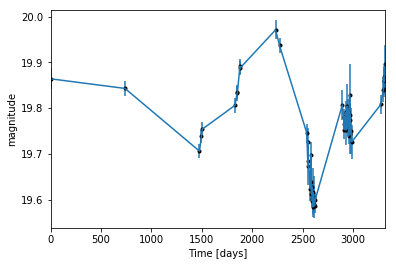

In [4]:
data = np.genfromtxt('LC_G_18822.dat')
juldate = data[:,0]  # time is given by the julian date
t = juldate - juldate.min()  # set first time value to zero for convenience. units of t are days.
y = data[:,1]  # i-band magnitudes
yerr = data[:,2]  # standard deviation in the measurement noise

plt.errorbar(t, y, yerr=yerr)
plt.plot(t, y, 'k.')
plt.xlim(t.min(), t.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')

In [8]:
model = cm.CarmaModel(t, y, yerr, p=4, q=1)

In [9]:
%%capture capt
sample = model.run_mcmc(20000)

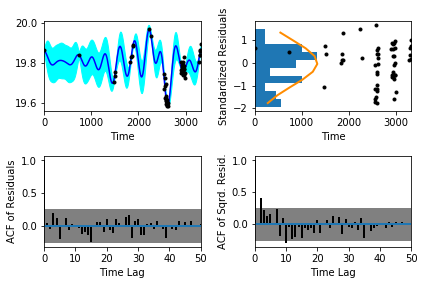

In [10]:
sample.assess_fit()

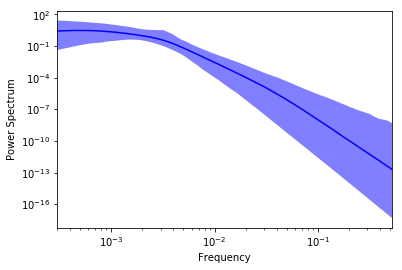

In [11]:


psd_low, psd_hi, psd_mid, frequencies = sample.plot_power_spectrum(percentile=95.0, nsamples=5000)



In [12]:
dt = t[1:] - t[:-1]
noise_level = 2.0 * np.mean(dt) * np.mean(yerr ** 2)

Text(0.000376389,0.0594048,'Nivel de ruido')

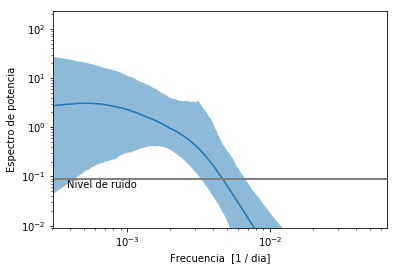

In [13]:
plt.loglog(frequencies, psd_mid)
plt.fill_between(frequencies, psd_hi, y2=psd_low, alpha=0.5)
plt.loglog(frequencies, np.ones(frequencies.size) * noise_level, color='grey', lw=2)
plt.ylim(noise_level / 10.0, plt.ylim()[1])
plt.xlim(frequencies.min(), frequencies[psd_hi > noise_level].max() * 10.0)
plt.ylabel('Espectro de potencia')
plt.xlabel('Frecuencia  [1 / dia]')
plt.annotate("Nivel de ruido", (1.25* plt.xlim()[0], noise_level / 1.5))

Text(0.5,1,'Forecasting, Expected Value')

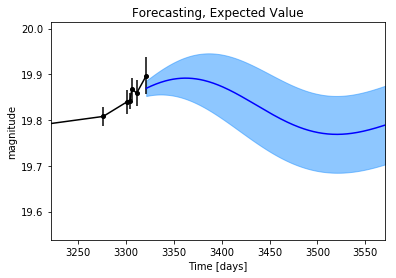

In [15]:
tpredict = t.max() + np.linspace(0.0, 250.0, 250)
ypredict, yp_var = sample.predict(tpredict)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tpredict, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tpredict, ypredict, 'b-')
plt.xlim(tpredict.min() - 100, tpredict.max())
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.title('Forecasting, Expected Value')

Text(0.5,1,'Forecasting, Simulated Paths')

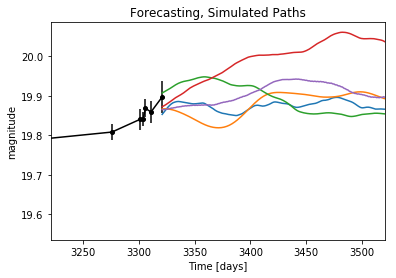

In [16]:
tpredict = t.max() + np.linspace(0.0, 200.0, 250)
npaths = 5
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
for i in range(npaths):
    ysim = sample.simulate(tpredict, bestfit='random')  # use a random draw of the CARMA parameters from its posterior
    plt.plot(tpredict, ysim)
plt.xlabel('Time [days]')
plt.ylabel('magnitude')
plt.xlim(tpredict.min()-100, tpredict.max())
plt.title('Forecasting, Simulated Paths')

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


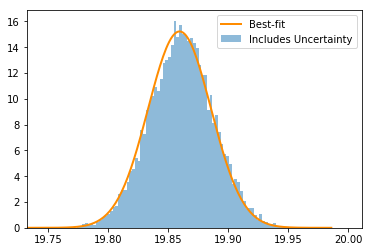

In [17]:
tpredict = 10.0
nsim = 10000
ysim = np.zeros(nsim)
for i in range(nsim):
    ysim[i] = sample.simulate(tpredict, bestfit='random')
yhat, yhvar = sample.predict(tpredict)
plt.hist(ysim, bins=100, alpha=0.5, histtype='stepfilled', normed=True, label='Includes Uncertainty')
ymin, ymax = plt.xlim()
ygrid = np.linspace(ymin, ymax, 200)
predictive_pdf = 1.0 / np.sqrt(2.0 * np.pi * yhvar) * np.exp(-0.5 * (ygrid - yhat) ** 2 / yhvar)
plt.plot(ygrid, predictive_pdf, color='DarkOrange', lw=2, label='Best-fit')
plt.xlim(ymin, ymax + 0.1 * (ymax - ymin))
plt.legend(loc='upper right')

Text(0.5,1,'Interpolacion, camino simulado')

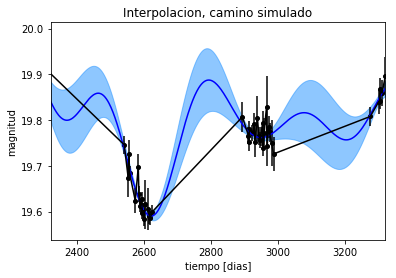

In [18]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
ypredict, yp_var = sample.predict(tinterp)
plt.errorbar(t, y, yerr=yerr, color='black')
plt.plot(t, y, 'ko', ms=4)
plt.fill_between(tinterp, ypredict+np.sqrt(yp_var), y2=ypredict-np.sqrt(yp_var), color='DodgerBlue', alpha=0.5)
plt.plot(tinterp, ypredict, 'b-')
plt.xlabel('tiempo [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

Text(0.5,1,'Interpolacion, camino simulado')

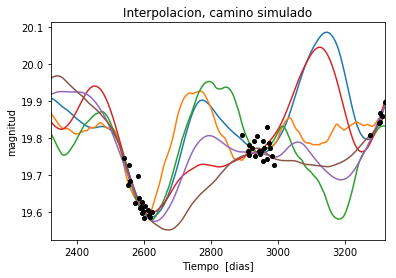

In [28]:
tinterp = t.max() - 1000 + np.linspace(0.0, 1000.0, 500)
npaths = 6
for i in range(npaths):
    ysim = sample.simulate(tinterp, bestfit='random')
    plt.plot(tinterp, ysim)
plt.plot(t, y, 'ko', ms=4)
plt.xlabel('Tiempo  [dias]')
plt.ylabel('magnitud')
plt.xlim(tinterp.min(), tinterp.max())
plt.title('Interpolacion, camino simulado')

In [29]:
sample.parameters

['quad_coefs',
 'logpost',
 'ar_coefs',
 'mu',
 'psd_centroid',
 'loglik',
 'psd_width',
 'var',
 'measerr_scale',
 'sigma',
 'ma_coefs',
 'ar_roots']

In [30]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [31]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 541.166553041
Median: 0.00264994120168
Standard deviation: 0.175344772258
68% credibility interval: [ 0.          0.05184592]
95% credibility interval: [ 0.         0.7001099]
99% credibility interval: [ 0.          0.98729948]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 541.166553041
Median: 0.00264994120168
Standard deviation: 0.175344772258
68% credibility interval: [ 0.          0.05184592]
95% credibility interval: [ 0.         0.7001099]
99% credibility interval: [ 0.          0.98729948]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 536.810105639
Median: 0.0
Standard deviation: 0.000778919385174
68% cred

Plotting parameter summary


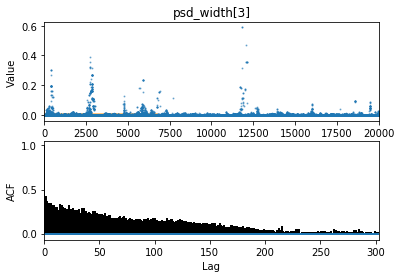

In [32]:
sample.plot_parameter('psd_width', 3, doShow=True)

In [33]:
centroid_samples = sample.get_samples('logpost')
centroid_samples.shape

(20000, 1)

In [34]:
sample.posterior_summaries('logpost')

Calculating effective number of samples
Posterior summary for parameter logpost  element 0
----------------------------------------------
Effective number of independent samples: 514.172795302
Median: 139.207893225
Standard deviation: 1.91391751027
68% credibility interval: [ 137.18703398  140.71180559]
95% credibility interval: [ 134.50418376  142.18781189]
99% credibility interval: [ 132.4710189   143.12339644]


In [35]:
centroid_samples = sample.get_samples('ar_coefs')
centroid_samples.shape

(20000, 5)

In [36]:
sample.posterior_summaries('ar_coefs')

Calculating effective number of samples
Posterior summary for parameter ar_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ar_coefs  element 1
----------------------------------------------
Effective number of independent samples: 339.736293774
Median: 0.346104073448
Standard deviation: 1.93371628066
68% credibility interval: [ 0.03645669  3.1357905 ]
95% credibility interval: [ 0.01274534  6.46804498]
99% credibility interval: [ 0.00995878  9.14164732]
Posterior summary for parameter ar_coefs  element 2
----------------------------------------------
Effective number of independent samples: 1135.44114792
Median: 0.0373333892888
Standard deviation: 6.17448684122
68% credibility interval: [  1.21146473e-03   1.69940329e+00]
95% credibility interval: [  4.

In [37]:
centroid_samples = sample.get_samples('ma_coefs')
centroid_samples.shape

(20000, 2)

In [38]:
sample.posterior_summaries('ma_coefs')

Calculating effective number of samples
Posterior summary for parameter ma_coefs  element 0
----------------------------------------------
Effective number of independent samples: nan
Median: 1.0
Standard deviation: 0.0
68% credibility interval: [ 1.  1.]
95% credibility interval: [ 1.  1.]
99% credibility interval: [ 1.  1.]
Posterior summary for parameter ma_coefs  element 1
----------------------------------------------
Effective number of independent samples: 1765.7255851
Median: 5.29082017386e-13
Standard deviation: 1.63075427892e+146
68% credibility interval: [  1.61661944e-66   7.91424248e+73]
95% credibility interval: [  2.97261048e-151   2.57508041e+134]
99% credibility interval: [  5.57806454e-175   1.25802805e+144]


In [39]:
centroid_samples = sample.get_samples('mu')
centroid_samples.shape

(20000, 1)

In [40]:
sample.posterior_summaries('mu')

Calculating effective number of samples
Posterior summary for parameter mu  element 0
----------------------------------------------
Effective number of independent samples: 2797.67777563
Median: 19.8154937002
Standard deviation: 0.0492165121993
68% credibility interval: [ 19.77857992  19.85698169]
95% credibility interval: [ 19.72663737  19.92363114]
99% credibility interval: [ 19.65768972  19.98284466]


In [41]:
centroid_samples = sample.get_samples('psd_centroid')
centroid_samples.shape

(20000, 4)

In [42]:
sample.posterior_summaries('psd_centroid')

Calculating effective number of samples
Posterior summary for parameter psd_centroid  element 0
----------------------------------------------
Effective number of independent samples: 541.166553041
Median: 0.00264994120168
Standard deviation: 0.175344772258
68% credibility interval: [ 0.          0.05184592]
95% credibility interval: [ 0.         0.7001099]
99% credibility interval: [ 0.          0.98729948]
Posterior summary for parameter psd_centroid  element 1
----------------------------------------------
Effective number of independent samples: 541.166553041
Median: 0.00264994120168
Standard deviation: 0.175344772258
68% credibility interval: [ 0.          0.05184592]
95% credibility interval: [ 0.         0.7001099]
99% credibility interval: [ 0.          0.98729948]
Posterior summary for parameter psd_centroid  element 2
----------------------------------------------
Effective number of independent samples: 536.810105639
Median: 0.0
Standard deviation: 0.000778919385174
68% cred

In [43]:
centroid_samples = sample.get_samples('loglik')
centroid_samples.shape

(20000, 1)

In [44]:
sample.posterior_summaries('loglik')

Calculating effective number of samples
Posterior summary for parameter loglik  element 0
----------------------------------------------
Effective number of independent samples: 514.172795302
Median: 139.207893225
Standard deviation: 1.91391751027
68% credibility interval: [ 137.18703398  140.71180559]
95% credibility interval: [ 134.50418376  142.18781189]
99% credibility interval: [ 132.4710189   143.12339644]


In [45]:
centroid_samples = sample.get_samples('psd_width')
centroid_samples.shape

(20000, 4)

In [46]:
sample.posterior_summaries('psd_width')

Calculating effective number of samples
Posterior summary for parameter psd_width  element 0
----------------------------------------------
Effective number of independent samples: 910.875120247
Median: 0.00249402135677
Standard deviation: 0.169210205708
68% credibility interval: [ 0.00060354  0.06952018]
95% credibility interval: [  3.51269412e-04   7.12821503e-01]
99% credibility interval: [  3.10622777e-04   9.45769878e-01]
Posterior summary for parameter psd_width  element 1
----------------------------------------------
Effective number of independent samples: 891.657343934
Median: 0.00126055138759
Standard deviation: 0.0670397374147
68% credibility interval: [ 0.0004878   0.00621952]
95% credibility interval: [ 0.00033348  0.14133198]
99% credibility interval: [  3.05744554e-04   6.12063985e-01]
Posterior summary for parameter psd_width  element 2
----------------------------------------------
Effective number of independent samples: 258.122719777
Median: 0.0100240628759
Standard

In [47]:
centroid_samples = sample.get_samples('var')
centroid_samples.shape

(20000, 1)

In [48]:
sample.posterior_summaries('var')

Calculating effective number of samples
Posterior summary for parameter var  element 0
----------------------------------------------
Effective number of independent samples: 1662.49445416
Median: 0.0130404316549
Standard deviation: 0.0181187479863
68% credibility interval: [ 0.00749587  0.02562193]
95% credibility interval: [ 0.00506684  0.05569153]
99% credibility interval: [ 0.00413451  0.10847495]


In [49]:
centroid_samples = sample.get_samples('measerr_scale')
centroid_samples.shape

(20000, 1)

In [50]:
sample.posterior_summaries('measerr_scale')

Calculating effective number of samples
Posterior summary for parameter measerr_scale  element 0
----------------------------------------------
Effective number of independent samples: 1619.59703004
Median: 0.860610685358
Standard deviation: 0.132569606512
68% credibility interval: [ 0.74356686  1.00647259]
95% credibility interval: [ 0.64378308  1.1558195 ]
99% credibility interval: [ 0.58978274  1.25742406]


In [51]:
centroid_samples = sample.get_samples('sigma')
centroid_samples.shape

(20000, 1)

In [52]:
sample.posterior_summaries('sigma')

Calculating effective number of samples
Posterior summary for parameter sigma  element 0
----------------------------------------------
Effective number of independent samples: 3264.19744641
Median: 3.58824175741e-06
Standard deviation: 0.00589094871636
68% credibility interval: [  1.38584233e-79   4.95589275e-04]
95% credibility interval: [  4.30306573e-139   7.28052713e-003]
99% credibility interval: [  1.07188833e-148   1.50404233e-002]


In [53]:
centroid_samples = sample.get_samples('ar_roots')
centroid_samples.shape

(20000, 4)

In [54]:
sample.posterior_summaries('ar_roots')

Calculating effective number of samples
Posterior summary for parameter ar_roots  element 0
----------------------------------------------
Effective number of independent samples: 910.875120247
Median: (-0.0156703983447-0.0238979669636j)
Standard deviation: 1.53106004342
68% credibility interval: [-0.43680815+0.j         -0.00379216-0.01880515j]
95% credibility interval: [ -4.47878959e+00-3.93830343j  -2.20709081e-03-0.01760751j]
99% credibility interval: [ -5.94244740e+00+0.j          -1.95170047e-03-0.02224487j]
Posterior summary for parameter ar_roots  element 1
----------------------------------------------
Effective number of independent samples: 891.657343934
Median: (-0.00792027795743+0.0241442640903j)
Standard deviation: 1.17950158887
68% credibility interval: [-0.03907837+0.01273484j -0.00306492+0.00117209j]
95% credibility interval: [-0.88801504+2.81535418j -0.00209530+0.j        ]
99% credibility interval: [ -3.84571144e+00+4.24081726j  -1.92104969e-03+0.01993145j]
Posterior

Plotting 2d PDF w KDE


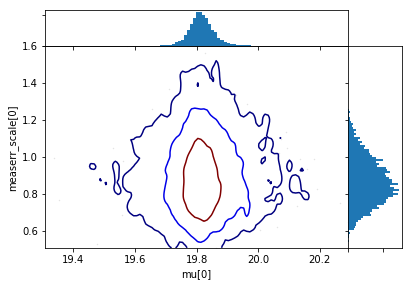

In [55]:
sample.plot_2dkde('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


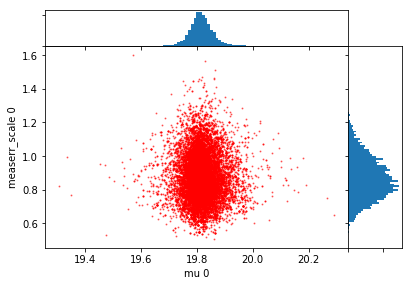

In [56]:
sample.plot_2dpdf('mu', 'measerr_scale', doShow=True)

Plotting 2d PDF


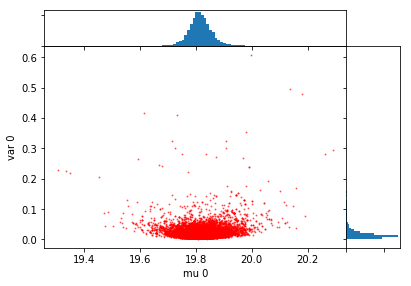

In [57]:
sample.plot_2dpdf('mu', 'var', doShow=True)

Plotting 2d PDF w KDE


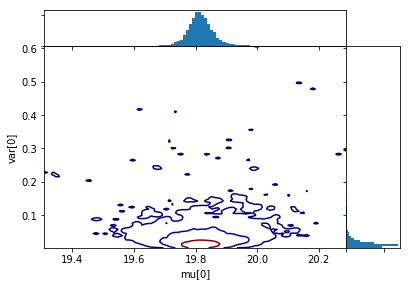

In [58]:
sample.plot_2dkde('mu', 'var', doShow=True)